# Final Project : Newspaper Search & Face Detection #

### The Assignment ###

Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

Accumulating information about the text and images in the newspaper...
This operation may take a few minutes ...
a-0.png
a-1.png
a-2.png
a-3.png


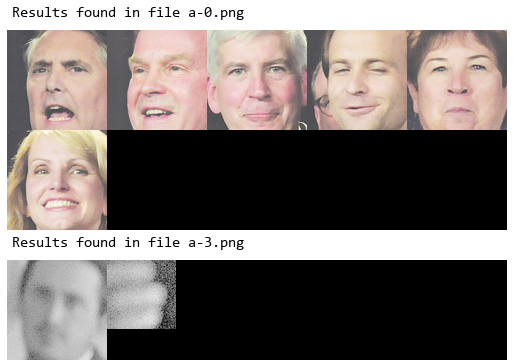

Accumulating information about the text and images in the newspaper...
This operation may take a few minutes ...
a-0.png
a-1.png
a-10.png
a-11.png
a-12.png
a-13.png
a-2.png
a-3.png
a-4.png
a-5.png
a-6.png
a-7.png
a-8.png
a-9.png


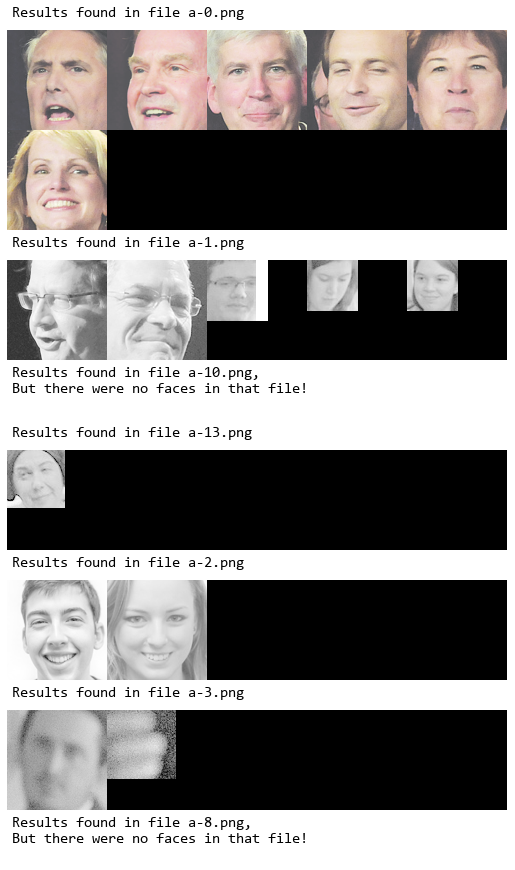

In [4]:
# Import necessary libraries
from zipfile import ZipFile
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to find bounding boxes of faces in an image
def bounding_boxes_array(image):
    # Load face cascade classifier
    face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
    # Convert image to grayscale
    cv_image = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(cv_image, scaleFactor=1.3, minNeighbors=6)
    return faces

# Function to create a list of cropped faces from bounding boxes
def cropped_faces_list(bounding_boxes, img):
    cropped_faces = []
    # Sort bounding boxes based on area
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[2] * box[3], reverse=True)
    for (x, y, w, h) in bounding_boxes:
        # Crop faces from the image
        cropped_face = img.crop((x, y, x + w, y + h))
        cropped_faces.append(cropped_face)
    return cropped_faces

# Function to create a contact sheet of images
def contact_sheet(images):
    thumbnail_width = 100
    thumbnail_height = 100
    row_number = (len(images) + 4) // 5
    
    contact_sheet = Image.new("RGB", (thumbnail_width * 5, thumbnail_height * row_number))
    x = 0
    y = 0
    
    for img in images:
        img.thumbnail((thumbnail_width, thumbnail_height))
        contact_sheet.paste(img, (x, y))
        x += thumbnail_width
        if x >= contact_sheet.width:
            x = 0
            y += thumbnail_height
    return contact_sheet, row_number

# Function to find faces related to a specific word
def word_related_faces(word, diction):
    printed_text =''
    if word in diction['text']:
        if len(diction['bounding_boxes']) != 0: 
            printed_text = 'Results found in file {}'.format(diction['image_name'])
        else:
            printed_text = "Results found in file {},\nBut there were no faces in that file!".format(diction['image_name'])
    return printed_text 

# Function to generate result image with faces related to a word
def result_image(data, word):
    thumbnail_width = 100
    thumbnail_height = 100
    total_contact_sheet_height = 0
    total_text_height = 0
    text_spacing = 30
    font_size = 15
    images_with_text = []
    
    for diction in data:
        if word in diction['text']:
            contact_sheet_img, rows = contact_sheet(cropped_faces_list(diction['bounding_boxes'], diction['image']))
            total_contact_sheet_height += contact_sheet_img.height
            
            printed_text = word_related_faces(word, diction)
            
            if len(diction['bounding_boxes']) != 0:
                text_img = Image.new('RGB', (contact_sheet_img.width , text_spacing), color='white')
            else :
                text_img = Image.new('RGB', (contact_sheet_img.width , text_spacing*2), color='white')
            total_text_height += text_img.height 
            draw = ImageDraw.Draw(text_img)
            font = ImageFont.truetype("readonly/consolas_font.ttf",font_size)  # Using default font for the text
            draw.text((5,5), printed_text, fill='black', font=font)
            
            images_with_text.append(text_img)
            images_with_text.append(contact_sheet_img)
    
    combined_image = Image.new('RGB', (500 + 15, total_contact_sheet_height + total_text_height), color='white')
   
    y_offset = 0
    for num_img in enumerate(images_with_text):
        combined_image.paste(num_img[1], (7, y_offset))
        y_offset += num_img[1].height
    
    # Display the combined image
    display(combined_image)

# Function to accumulate data from images in a zip folder
def accum_data(Zipfolder):
    data = []
    print("Accumulating information about the text and images in the newspaper...\nThis operation may take a few minutes ...")
    for image_name in Zipfolder.namelist():
        print(image_name)
        img = Zipfolder.open(image_name)
        I = Image.open(img).convert('RGB')
        text = pytesseract.image_to_string(I)
        img_dict = {
            'image': I,
            'image_name': image_name,
            'bounding_boxes': bounding_boxes_array(I),
            'text': text
        }
        data.append(img_dict)
    return data

# Process small image zip file for word "Christopher"
smallzip = ZipFile('readonly/small_img.zip', 'r')
word1 = "Christopher"
result_image(accum_data(smallzip), word1)

# Process large image zip file for word "Mark"
largzip = ZipFile('readonly/images.zip', 'r')
word2 = "Mark"
result_image(accum_data(largzip), word2)
